In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Read a pandas DataFrame
aapl_df = pd.read_csv('AAPL.csv')
aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0


In [2]:
remaining_missing_values = aapl_df.isnull().sum()
print(remaining_missing_values)

Date                0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
ts_polarity       266
twitter_volume    266
dtype: int64


In [3]:
# Apply linear interpolation to fill missing values
aapl_df['ts_polarity'] = aapl_df['ts_polarity'].interpolate(method='linear')
aapl_df['twitter_volume'] = aapl_df['twitter_volume'].interpolate(method='linear')
# aapl_df['Open'] = aapl_df['Open'].interpolate(method='linear')
# aapl_df['High'] = aapl_df['High'].interpolate(method='linear')
# aapl_df['Low'] = aapl_df['Low'].interpolate(method='linear')
# aapl_df['Close'] = aapl_df['Close'].interpolate(method='linear')
# aapl_df['Adj Close'] = aapl_df['Adj Close'].interpolate(method='linear')
# aapl_df['Volume'] = aapl_df['Volume'].interpolate(method='linear')

# Check if there are any remaining missing values after interpolation
remaining_missing_values = aapl_df.isnull().sum()
print(remaining_missing_values)

Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
ts_polarity       0
twitter_volume    0
dtype: int64


In [4]:
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.set_index('Date', inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Define columns to scale
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ts_polarity', 'twitter_volume']

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the columns
aapl_df[columns_to_scale] = scaler.fit_transform(aapl_df[columns_to_scale])
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2016-01-04,0.027370,0.029724,0.028939,0.033692,0.028678,0.461343,0.393205,0.135932
2016-01-05,0.034234,0.030767,0.029863,0.027778,0.023278,0.364149,0.581540,0.174019
2016-01-06,0.022939,0.023205,0.024038,0.023208,0.019118,0.467966,0.398128,0.240575
2016-01-07,0.018855,0.018338,0.016087,0.013710,0.010444,0.571541,0.405057,0.284175
2016-01-08,0.018594,0.016165,0.016827,0.014875,0.011506,0.487150,0.337240,0.277251


In [6]:
# Splitting the data into training and validation sets
train_size = int(len(aapl_df) * 0.8)  # 80% for training
training_set = aapl_df.iloc[:train_size]
validation_set = aapl_df.iloc[train_size:]

In [7]:
from darts import TimeSeries
from darts.models import XGBModel

# Load your data into a DataFrame (assuming it's already loaded in `aapl_df`)
aapl_df.index = pd.to_datetime(aapl_df.index)  # Ensure the index is datetime

frequency = 'D'
# Create TimeSeries objects from the DataFrame
target = TimeSeries.from_dataframe(aapl_df, value_cols=['Close'], freq=frequency)
past_cov = TimeSeries.from_dataframe(aapl_df, value_cols=['Open', 'High', 'Low', 'Adj Close', 'Volume'], freq=frequency)

C:\Users\TEO\anaconda3\envs\darts\Lib\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
# Convert TimeSeries back to DataFrame to check for NaNs or Infs
target_df = target.pd_dataframe()
past_covariates_df = past_cov.pd_dataframe()

# Checking for NaNs
print("NaNs in target:", target_df.isna().sum())
print("NaNs in past_covariates:", past_covariates_df.isna().sum())

# Checking for Infs
print("Infs in target:", np.isinf(target_df.values).sum())
print("Infs in past_covariates:", np.isinf(past_covariates_df.values).sum())

NaNs in target: component
Close    535
dtype: int64
NaNs in past_covariates: component
Open         535
High         535
Low          535
Adj Close    535
Volume       535
dtype: int64
Infs in target: 0
Infs in past_covariates: 0


In [9]:
# Fill NaNs with a method of your choice, here using forward fill as an example
target_df.fillna(method='ffill', inplace=True)
past_covariates_df.fillna(method='ffill', inplace=True)

# Replace Infs with NaN and then fill or drop
target_df.replace([np.inf, -np.inf], np.nan, inplace=True)
past_covariates_df.replace([np.inf, -np.inf], np.nan, inplace=True)
target_df.fillna(method='ffill', inplace=True)  # or use another appropriate method
past_covariates_df.fillna(method='ffill', inplace=True)

# Convert back to TimeSeries if necessary
target = TimeSeries.from_dataframe(target_df)
past_covariates = TimeSeries.from_dataframe(past_covariates_df)

C:\Users\TEO\AppData\Local\Temp\ipykernel_13452\3172371903.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target_df.fillna(method='ffill', inplace=True)
C:\Users\TEO\AppData\Local\Temp\ipykernel_13452\3172371903.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  past_covariates_df.fillna(method='ffill', inplace=True)
C:\Users\TEO\AppData\Local\Temp\ipykernel_13452\3172371903.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target_df.fillna(method='ffill', inplace=True)  # or use another appropriate method
C:\Users\TEO\AppData\Local\Temp\ipykernel_13452\3172371903.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 7.4 M 
4 | V             | Linear           | 513   
---------------------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.436    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 31/31 [00:14<00:00,  2.18it/s, train_loss=0.00704]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 31/31 [00:14<00:00,  2.15it/s, train_loss=0.00545, val_loss=0.0269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 31/31 [00:14<00:00,  2.14it/s, train_loss=0.00742, val_loss=0.0308]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 31/31 [00:14<00:00,  2.18it/s, train_loss=0.00405, val_loss=0.0329]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 31/31 [00:14<00:00,  2.18it/s, train_loss=0.00563, val_loss=0.0304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s, train_loss=0.00649, val_loss=0.0274]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s, train_loss=0.00782, val_loss=0.0282]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 31/31 [00:1

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:14<00:00,  2.15it/s, train_loss=0.00781, val_loss=0.030]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


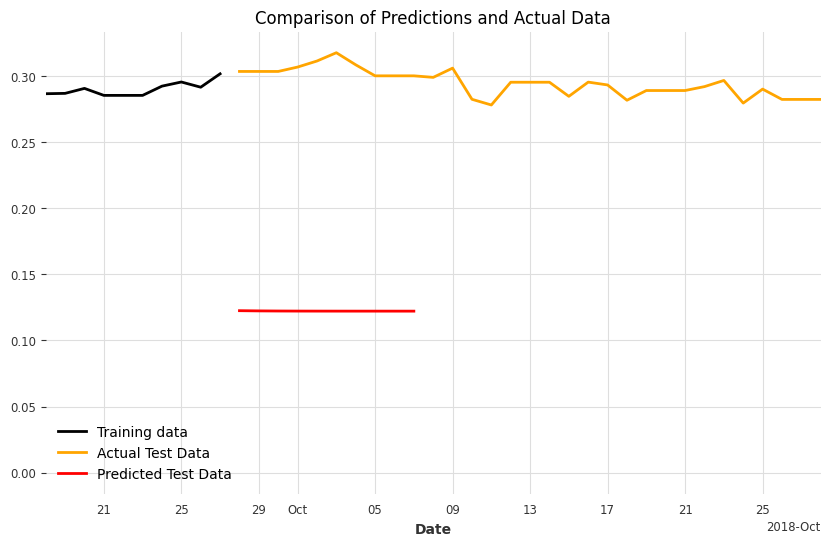

In [12]:
from darts.models import RNNModel

# Adjusting the split to ensure that past_covariates cover at least 10 days before training starts
train_target, temp_target = target.split_before(pd.Timestamp('2018-09-28'))
train_covariates, temp_covariates = past_covariates.split_before(pd.Timestamp('2018-09-18'))  # Adjusted to include ten days prior

# Ensuring the test covariates start from the adjusted earlier date
test_covariates = temp_covariates.slice(pd.Timestamp('2018-09-18'), pd.Timestamp('2018-10-28'))

# Adjusting the test target similarly to start from the same day as test covariates for clarity in example
test_target = temp_target.slice(pd.Timestamp('2018-09-28'), pd.Timestamp('2018-10-28'))

model = RNNModel(
    model="LSTM",
    input_chunk_length=3,
    training_length=9,
    n_epochs=20,
    hidden_dim=50,
    n_rnn_layers=2,
    dropout=0.2,
    optimizer_kwargs={'lr': 1e-3, 'weight_decay': 1e-4}
)

# Fit the model with validation data
model.fit(series=train_target, val_series=test_target, verbose=True)

# Prediction
predicted = model.predict(n=10, series=train_target)

# Visualization
plt.figure(figsize=(10, 6))
train_target.plot(label='Training data')
test_target.plot(label='Actual Test Data', color='orange')
predicted.plot(label='Predicted Test Data', color='red')
start_date = test_target.start_time() - pd.Timedelta(days=10)  # 10 days before the test data starts
end_date = test_target.end_time()  # End of the test data
plt.xlim(start_date, end_date)
plt.title('Comparison of Predictions and Actual Data')
plt.legend()
plt.show()